<a href="https://colab.research.google.com/github/gabodabo-uno/DLA2501_DeepLearning/blob/cloud_v/Exam01/3.%20Programas/02_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from itertools import chain
import re
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
el_path_main = Path(os.getcwd()).parent

# Load Dataset

In [4]:
df = pd.read_excel(el_path_main/'2. Datos/df_consol.xlsx')
df.head()

,file_name,code,language,dataset_type
0,s819985569.php,<?php\n//??????????????¬??????????????????????...,PHP,train
1,s085505690.php,"<?php\n\ndefine( 'NONE', -1 );\n\nclass AOJ103...",PHP,train
2,s899955607.php,"<?php\n const DIRS = array('R','D','L','U');\...",PHP,train
3,s660365995.php,<?php\n//その都度計算しているとTLEになるので、最初に$max値で計算\n \n$...,PHP,train
4,s682378491.php,<?php\nwhile (true) {\n $line = trim(fgets(...,PHP,train


# Limpieza
En este caso el análsis será por letra, no por palabra. Además, las mayusc son distintas a las minusc. Además, apoyados de Chat GPT, generamos un excel que me indica las formas de genera comentarios en cada lenguaje de programación:
- _Create an Excel file containing expressions used to create comments in different programming languages."_

Esto lo vamos a usar para limpiar los códigos y quedarnos solo con el código sin comentarios

In [5]:
df_excel_comments = pd.read_excel(el_path_main/'2. Datos/comment_syntax_selected_languages.xlsx')
df_excel_comments[df_excel_comments['Programming Language'].isin(df['language'].value_counts().index)]

,Programming Language,Single-line Comment,Multi-line Comment
0,PHP,// comment,/* comment */
1,JavaScript,// comment,/* comment */
2,Rust,// comment,/* comment */
3,C,// comment,/* comment */
4,D,// comment,/* comment */
5,Haskell,-- comment,{- comment -}
6,Java,// comment,/* comment */
7,C++,// comment,/* comment */
8,C#,// comment,/* comment */
9,Python,# comment,""""""" comment """""""


In [6]:
# Function to find all occurrences of a character in a string
def busca_all_char_ocur(text, char_to_find):
    positions = []
    start = 0
    while True:
        position = text.find(char_to_find, start)
        if position == -1:
            break
        positions.append(position)
        start = position + 1
    return positions

In [7]:
# Usage example:
text = "Hello, world! Hello, universe!"
char_to_find = 'Hello'
busca_all_char_ocur(text, char_to_find)

[0, 14]

In [8]:
# Function to find posible end of comments in any lenguage code
def get_end_posible(index_ini, df_posibles_end, col_end_comentario = 'end_comentario'):
    df_posibles_end_copy = df_posibles_end.copy()
    par_ordenado_inicio_fin = []
    for i in index_ini:
        # Para cada posible end del comentario creamos una diferencia para saber cual es el más cercano
        df_posibles_end_copy['dif'] = df_posibles_end_copy[col_end_comentario] - i
        df_posibles_end_copy = df_posibles_end_copy[df_posibles_end_copy['dif'] > 0]
        try:
            el_mini_index_df = df_posibles_end_copy['dif'].idxmin()
            el_end = df_posibles_end_copy.loc[el_mini_index_df, col_end_comentario]
        except:
            el_mini_index_df = -1
            el_end = 999_999_999 # Colocamos el último posible caracter del code
        par_ordenado_inicio_fin.append([i, el_end])
    return par_ordenado_inicio_fin

In [9]:
# Function to get rid of comments in code
def busca_elimina_cadenas_comment_single_line(code, char_comment):

    # Identificamos el index del posible inicio de un comentario de una sola línea
    el_index_single_line = busca_all_char_ocur(code, char_comment)
    end_comentario = busca_all_char_ocur(code, '\n')

    # Identificamos donde termina el comentario de una sola línea
    df_end_comentario = pd.DataFrame(end_comentario, columns=['end_comentario'])

    # Casos en que no haremos nada:
    # 1. No caracteres que indiquen el inicio de un comentario de una sola línea
    # 2. No caracteres que indiquen el final de un comentario de una sola línea (\n)
    if (len(el_index_single_line)==0)|(len(end_comentario)==0) :
        # No hay comentarios de una sola línea
        return code
    if len(el_index_single_line) > 0 :
        lista_pares_ini_fin_comment = get_end_posible(index_ini = el_index_single_line, df_posibles_end = df_end_comentario)
        code_limpio = ''
        limpi_desde = 0
        for i in lista_pares_ini_fin_comment:
            limpi_hasta = i[0]
            code_limpio_tmp = code[limpi_desde:limpi_hasta]
            limpi_desde = i[1]
            code_limpio += code_limpio_tmp
        return code_limpio

In [10]:
# Funcion para eliminar comentarios de una sola línea en un código, pero teniendo en cuenta que hay un umbral de
#  eliminación que no quiero superar


# Caso 1: single line comment
def revisa_single_line_comment(code, verb=False, th_elim = 0.3):

    code_entrada = code

    # Caso de //
    caso_comment = '//'
    code_salida = busca_elimina_cadenas_comment_single_line(code_entrada, caso_comment)
    ptj_elim = len(code_salida)/len(code_entrada)-1

    # Si el porcentaje de eliminación es mayor al umbral, no se realizan los cambios
    if abs(ptj_elim) > abs(th_elim):
        code_entrada = code_entrada
        el_print = f'No se eliminaron comentarios de una sola línea por: {caso_comment}, se hubiera eliminado el {ptj_elim:.2%}'
    else:
        code_entrada = code_salida
        el_print = f'Porcentaje datos eliminados single line por {caso_comment}: {ptj_elim:.2%}'
    if verb:
        print(el_print)

    # Caso de --
    caso_comment = '--'
    code_salida = busca_elimina_cadenas_comment_single_line(code_entrada, caso_comment)
    ptj_elim = len(code_salida)/len(code_entrada)-1

    # Si el porcentaje de eliminación es mayor al umbral, no se realizan los cambios
    if abs(ptj_elim) > abs(th_elim):
        code_entrada = code_entrada
        el_print = f'No se eliminaron comentarios de una sola línea por: {caso_comment}, se hubiera eliminado el {ptj_elim:.2%}'
    else:
        code_entrada = code_salida
        el_print = f'Porcentaje datos eliminados single line por {caso_comment}: {ptj_elim:.2%}'
    if verb:
        print(el_print)

    # Caso de #
    caso_comment = '#'
    code_salida = busca_elimina_cadenas_comment_single_line(code_entrada, caso_comment)
    ptj_elim = len(code_salida)/len(code_entrada)-1

    # Si el porcentaje de eliminación es mayor al umbral, no se realizan los cambios
    if abs(ptj_elim) > abs(th_elim):
        code_entrada = code_entrada
        el_print = f'No se eliminaron comentarios de una sola línea por: {caso_comment}, se hubiera eliminado el {ptj_elim:.2%}'
    else:
        code_entrada = code_salida
        el_print = f'Porcentaje datos eliminados single line por {caso_comment}: {ptj_elim:.2%}'
    if verb:
        print(el_print)

    return code_entrada

In [11]:
revisa_single_line_comment(df.loc[999,'code'], verb=True)

Porcentaje datos eliminados single line por //: 0.00%
Porcentaje datos eliminados single line por --: 0.00%
No se eliminaron comentarios de una sola línea por: #, se hubiera eliminado el -60.30%


"#! -*- coding: utf-8-unix -*-\nimport math\n\nif __name__=='__main__':\n  # lines = [x.strip() for x in sys.stdin.readlines() if x != '' and x != '\\n']\n  # n = int(lines[0])\n  n = int(raw_input())\n  for i in xrange(n):\n    # x1, y1, x2, y2, x3, y3, x4, y4 = map(float, lines[i+1].split(' '))\n    x1, y1, x2, y2, x3, y3, x4, y4 = map(float, raw_input().strip().split(' '))\n    # if x1 == x2 or x3 == x4:\n    #   if x1 == x2 and x3 == x4:\n    #     print 'YES'\n    #   else:\n    #     print 'NO'\n    #   continue\n    # elif y1 == y2 or y3 == y4:\n    #   if y1 == y2 and y3 == y4:\n    #     print 'YES'\n    #   else:\n    #     print 'NO'\n    #   continue\n    # else:\n      # if (y2 - y1) * (x4 - x3) == (y4 - y3) * (x2 - x1):\n    if math.fabs((y2 - y1) * (x4 - x3) - (y4 - y3) * (x2 - x1)) < 1e-10:\n      print 'YES'\n    else:\n      print 'NO'\n      # a1 = (y2 - y1) / (x2 - x1)\n      # b1 = y1 - a1 * x1\n      # a2 = (y4 - y3) / (x4 - x3)\n      # b2 = y3 - a2 * x3\n      #

In [12]:
revisa_single_line_comment(df.loc[272,'code'], verb=True)

Porcentaje datos eliminados single line por //: -28.19%
Porcentaje datos eliminados single line por --: -3.60%
No se eliminaron comentarios de una sola línea por: #, se hubiera eliminado el -99.95%


'#include<stdio.h>\n#include<stdlib.h>\n\nvoid* cmalloc(int size, char* em){\n\t\n\t\n\t\n\tvoid* ob = malloc(size);\n\tif(ob == NULL){\n\t\tprintf("We can\'t ensure plenty memory in this program. %s \\n", em);\n\t\texit(0);\n\t}\n    return ob;\n}\n\nvoid* crealloc(void* ob, int size, char* em){\n\t\n\t\n\t\n\t\n\t\n\tvoid* ret = realloc(ob, size);\n\tif(ret == NULL){\n\t\tprintf("We can\'t re-ensure plenty memory in this program. %s \\n", em);\n\t\texit(0);\n\t}\n\treturn ret;\n}\n\ntypedef struct {\n\tint* arp;\n\tint size;\n\tint stack_size;\n}vector_i;\n\nint* vector_i_at(const vector_i* ob, int idx){\n\t\n\tif(ob->size <= idx){\n\t\tprintf("at-access in vector overes the range.\\n");\n\t\texit(0);\n\t}\n\treturn (ob->arp + idx);\n}\n\nvoid vector_i_private_increase(vector_i* ob, int size){\n\twhile(ob->stack_size < size)ob->stack_size *= 2;\n}\n\nvoid vector_i_constructor(vector_i* ob, int size){\n\t\n\tob->size = size;\n\tob->stack_size = 1;\n\tvector_i_private_increase(ob, size

In [13]:

df['code_no_comments'] = df['code'].apply(lambda x: revisa_single_line_comment(x, th_elim=0.7))

In [14]:
print(df.loc[999,'code'])

#! -*- coding: utf-8-unix -*-
import math

if __name__=='__main__':
  # lines = [x.strip() for x in sys.stdin.readlines() if x != '' and x != '\n']
  # n = int(lines[0])
  n = int(raw_input())
  for i in xrange(n):
    # x1, y1, x2, y2, x3, y3, x4, y4 = map(float, lines[i+1].split(' '))
    x1, y1, x2, y2, x3, y3, x4, y4 = map(float, raw_input().strip().split(' '))
    # if x1 == x2 or x3 == x4:
    #   if x1 == x2 and x3 == x4:
    #     print 'YES'
    #   else:
    #     print 'NO'
    #   continue
    # elif y1 == y2 or y3 == y4:
    #   if y1 == y2 and y3 == y4:
    #     print 'YES'
    #   else:
    #     print 'NO'
    #   continue
    # else:
      # if (y2 - y1) * (x4 - x3) == (y4 - y3) * (x2 - x1):
    if math.fabs((y2 - y1) * (x4 - x3) - (y4 - y3) * (x2 - x1)) < 1e-10:
      print 'YES'
    else:
      print 'NO'
      # a1 = (y2 - y1) / (x2 - x1)
      # b1 = y1 - a1 * x1
      # a2 = (y4 - y3) / (x4 - x3)
      # b2 = y3 - a2 * x3
      # if (a1 == a2):# and (b1 != b2):
 

In [15]:
print(df.loc[999,'code_no_comments'])


import math

if __name__=='__main__':
  
  
  n = int(raw_input())
  for i in xrange(n):
    
    x1, y1, x2, y2, x3, y3, x4, y4 = map(float, raw_input().strip().split(' '))
    
    
    
    
    
    
    
    
    
    
    
    
    
      
    if math.fabs((y2 - y1) * (x4 - x3) - (y4 - y3) * (x2 - x1)) < 1e-10:
      print 'YES'
    else:
      print 'NO'
      
      
      
      
      
      
      
      
    
    


In [16]:
df[df['language']=='C']

,file_name,code,language,dataset_type,code_no_comments
270,s275698564.c,"\n\n// j;main(i){for(;9/i;i+=!(j%=9))printf(""%...",C,train,"\n\n// j;main(i){for(;9/i;i+=!(j%=9))printf(""%..."
271,s957179855.c,"#include <stdio.h>\n\nint main(int argc, const...",C,train,"#include <stdio.h>\n\nint main(int argc, const..."
272,s637528533.c,#include<stdio.h>\n#include<stdlib.h>\n\nvoid*...,C,train,#include<stdio.h>\n#include<stdlib.h>\n\nvoid*...
273,s477259846.c,"#include <stdio.h>\nint Maxcheck(int *p,int *q...",C,train,"#include <stdio.h>\nint Maxcheck(int *p,int *q..."
274,s330822575.c,"#include <stdio.h>\n\n#define MIN(a,b) (((a)>(...",C,train,"#include <stdio.h>\n\n#define MIN(a,b) (((a)>(..."
...,...,...,...,...,...
935,s061913833.c,/*\n\naとbの最小公倍数、最大公約数を求めよ。\naとbは20億以下とする。\nただし...,C,test,/*\n\naとbの最小公倍数、最大公約数を求めよ。\naとbは20億以下とする。\nただし...
936,s037283393.c,#include <stdio.h>\n#include <stdlib.h>\n\n// ...,C,test,#include <stdio.h>\n#include <stdlib.h>\n\n// ...
937,s074878500.c,#include<stdio.h>\n\ntypedef struct eq\n{\n\ti...,C,test,#include<stdio.h>\n\ntypedef struct eq\n{\n\ti...
938,s039252775.c,#include <stdio.h>\n\nint main(void) \n{\n /*...,C,test,#include <stdio.h>\n\nint main(void) \n{\n /*...


In [17]:
df.loc[272, 'code']

'#include<stdio.h>\n#include<stdlib.h>\n\nvoid* cmalloc(int size, char* em){\n\t//malloc with checking.\n\t//in em, you can input some error message for identifying the error position.\n\t//if you don\'t input any in em, we won\'t output any extra message.\n\tvoid* ob = malloc(size);\n\tif(ob == NULL){\n\t\tprintf("We can\'t ensure plenty memory in this program. %s \\n", em);\n\t\texit(0);\n\t}\n    return ob;\n}\n\nvoid* crealloc(void* ob, int size, char* em){\n\t//realloc with checking.\n\t//in em, you can input some error message for identifying the error position.\n\t//if you don\'t input any in em, we won\'t output any extra message.\n\t//realloc cost linear time depeding size at worst.\n\t\n\tvoid* ret = realloc(ob, size);\n\tif(ret == NULL){\n\t\tprintf("We can\'t re-ensure plenty memory in this program. %s \\n", em);\n\t\texit(0);\n\t}\n\treturn ret;\n}\n\ntypedef struct {\n\tint* arp;\n\tint size;\n\tint stack_size;\n}vector_i;\n\nint* vector_i_at(const vector_i* ob, int idx){

In [18]:
df.loc[272, 'code_no_comments']

'#include<stdio.h>\n#include<stdlib.h>\n\nvoid* cmalloc(int size, char* em){\n\t\n\t\n\t\n\tvoid* ob = malloc(size);\n\tif(ob == NULL){\n\t\tprintf("We can\'t ensure plenty memory in this program. %s \\n", em);\n\t\texit(0);\n\t}\n    return ob;\n}\n\nvoid* crealloc(void* ob, int size, char* em){\n\t\n\t\n\t\n\t\n\t\n\tvoid* ret = realloc(ob, size);\n\tif(ret == NULL){\n\t\tprintf("We can\'t re-ensure plenty memory in this program. %s \\n", em);\n\t\texit(0);\n\t}\n\treturn ret;\n}\n\ntypedef struct {\n\tint* arp;\n\tint size;\n\tint stack_size;\n}vector_i;\n\nint* vector_i_at(const vector_i* ob, int idx){\n\t\n\tif(ob->size <= idx){\n\t\tprintf("at-access in vector overes the range.\\n");\n\t\texit(0);\n\t}\n\treturn (ob->arp + idx);\n}\n\nvoid vector_i_private_increase(vector_i* ob, int size){\n\twhile(ob->stack_size < size)ob->stack_size *= 2;\n}\n\nvoid vector_i_constructor(vector_i* ob, int size){\n\t\n\tob->size = size;\n\tob->stack_size = 1;\n\tvector_i_private_increase(ob, size

In [19]:
# Caso 2: multi line comment
# This case will be considered in a following MVP

In [20]:
df['language'].value_counts()

language
PHP           100
JavaScript    100
Rust          100
C             100
D             100
Haskell       100
Java          100
C++           100
C#            100
Python        100
Name: count, dtype: int64

In [21]:
el_num_aleat = np.random.randint(1,1_000)
print(f'Número aleatorio: {el_num_aleat}')
print(df.loc[el_num_aleat, 'code'])

Número aleatorio: 128
// 標準入力
var fs = require('fs'),
length = fs.fstatSync(process.stdin.fd).size,
buffer = new Buffer(length),
bytesRead = fs.readSync(process.stdin.fd, buffer, 0, length, 0),
input = buffer.toString('utf8', 0, bytesRead).split('\n');
main();
  
function main(){
  var read = 0;
  var resultCase = 1;
  while(true){
    var maxWeight = +input[read++];
    if(!maxWeight){
      break;
    }
      
    var treasures = +input[read++];
    var pdp = new Int16Array(maxWeight + 1);
    for(var i = treasures; i--;){
      var c = input[read++].split(",");
      var tv = +c[0];
      var tw = +c[1];
  
      var dp = new Int16Array(maxWeight + 1);
      for(var w = 1; w <= maxWeight; w++){
        var pdpw = pdp[w];
        dp[w] = (w-tw < 0) ? pdpw : max(pdp[w-tw] + tv, pdpw);
      }
      pdp = dp;
    }
  
    var resultWeight = 1001;
    var resultCost = 0;
    for(var i = 0; i <= maxWeight; i++){
      var pdpi = pdp[i];
      if(pdpi > resultCost){
        resultCost = p

In [22]:
df.loc[290]

file_name                                                s511770803.c
code                #include <stdio.h>\n\n/*\n\n??£???????¨????\n\...
language                                                            C
dataset_type                                                    train
code_no_comments    #include <stdio.h>\n\n/*\n\n??£???????¨????\n\...
Name: 290, dtype: object

# Generación de otros features

In [23]:
# Veamos de que letras está acompañado el caracter "\n, \t"
rep_tab = ' ESTOESUNTABCREADOPORGSB '
rep_enter = ' ESTOESUNENTERCREADOPORGSB '
# Mantener los espacios en blanco para que en caso el code sea "print('aa')\nprint('bb') no se junte como una sola palabra"

df['code_2'] = df['code'].str.replace('\n', rep_enter)
df['code_2'] = df['code_2'].str.replace('\t', rep_tab)

df['count_ENTER'] = df['code'].str.count('\n')
df['count_TAB'] = df['code'].str.count('\t')

df['count_ENTER_no_comments'] = df['code_no_comments'].str.count('\n')
df['count_TAB_no_comments'] = df['code_no_comments'].str.count('\t')



In [24]:
df.groupby('dataset_type')[['count_TAB', 'count_ENTER', 'count_TAB_no_comments', 'count_ENTER_no_comments']].describe().T

dataset_type                         test       train
count_TAB               count  100.000000  900.000000
                        mean    19.200000   25.592222
                        std     47.394327   67.637549
                        min      0.000000    0.000000
                        25%      0.000000    0.000000
                        50%      0.000000    0.000000
                        75%      9.500000   11.000000
                        max    302.000000  654.000000
count_ENTER             count  100.000000  900.000000
                        mean    65.070000   66.441111
                        std     36.858247   39.182921
                        min     21.000000    0.000000
                        25%     45.500000   46.000000
                        50%     52.000000   53.000000
                        75%     78.000000   77.000000
                        max    245.000000  359.000000
count_TAB_no_comments   count  100.000000  900.000000
                        mean    15.850000   19.576667
                        std     44.525869   52.812444
                        min      0.000000    0.000000
                        25%      0.000000    0.000000
                        50%      0.000000    0.000000
                        75%      1.000000    1.000000
                        max    302.000000  518.000000
count_ENTER_no_comments count  100.000000  900.000000
                        mean    52.390000   55.157778
                        std     29.783357   30.588110
                        min     13.000000    0.000000
                        25%     33.750000   37.000000
                        50%     43.000000   47.000000
                        75%     66.250000   68.000000
                        max    160.000000  228.000000

In [25]:
# Ptj de caracteres que son ENTER y TAB
df['N_letras'] = df['code'].str.len()
df['ptj_ENTER'] = df['count_ENTER']/df['N_letras']
df['ptj_TAB'] = df['count_TAB']/df['N_letras']

df['N_letras_no_comments'] = df['code_no_comments'].str.len()
df['ptj_ENTER_no_comments'] = df['count_ENTER_no_comments']/df['N_letras_no_comments']
df['ptj_TAB_no_comments'] = df['count_TAB_no_comments']/df['N_letras_no_comments']

<Axes: >

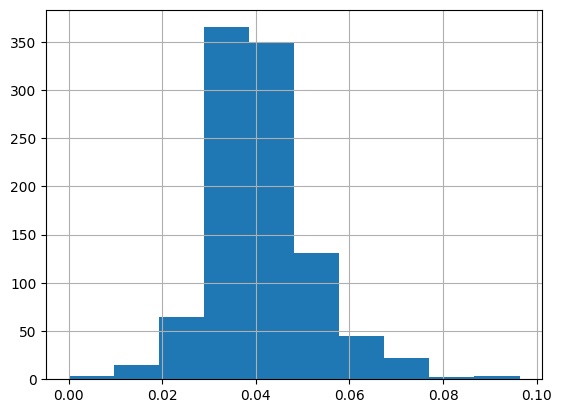

In [26]:
df['ptj_ENTER'].hist()

<Axes: xlabel='language', ylabel='ptj_ENTER'>

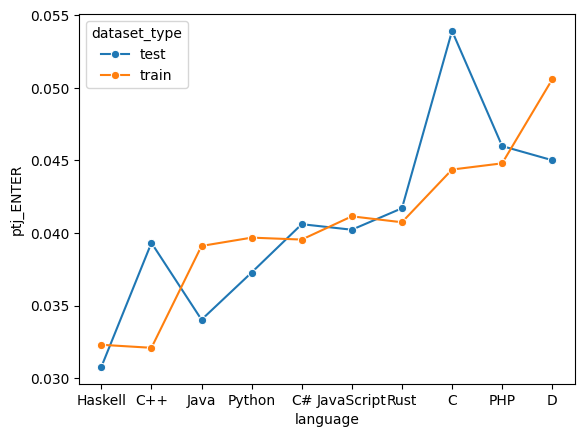

In [27]:
a = df.groupby(['language', 'dataset_type'])['ptj_ENTER'].mean().reset_index().sort_values('ptj_ENTER')
sns.lineplot(data=a, x='language', y='ptj_ENTER', hue='dataset_type', marker='o')

<Axes: xlabel='language', ylabel='ptj_ENTER_no_comments'>

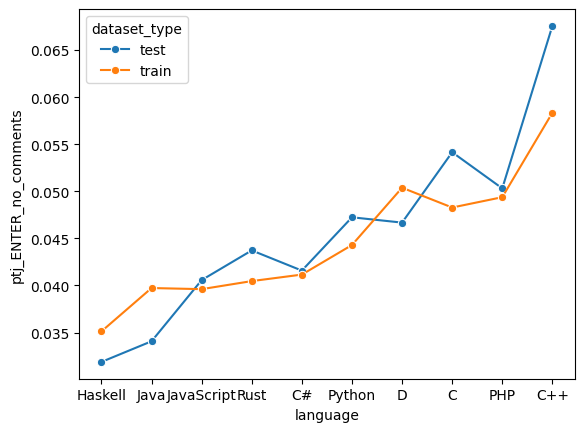

In [28]:
a = df.groupby(['language', 'dataset_type'])['ptj_ENTER_no_comments'].mean().reset_index().sort_values('ptj_ENTER_no_comments')
sns.lineplot(data=a, x='language', y='ptj_ENTER_no_comments', hue='dataset_type', marker='o')

<Axes: xlabel='language', ylabel='ptj_TAB'>

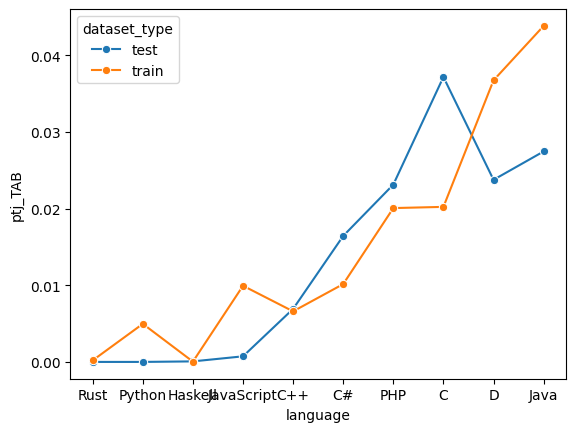

In [29]:
a = df.groupby(['language', 'dataset_type'])['ptj_TAB'].mean().reset_index().sort_values('ptj_TAB')
sns.lineplot(data=a, x='language', y='ptj_TAB', hue='dataset_type', marker='o')

<Axes: xlabel='language', ylabel='ptj_TAB_no_comments'>

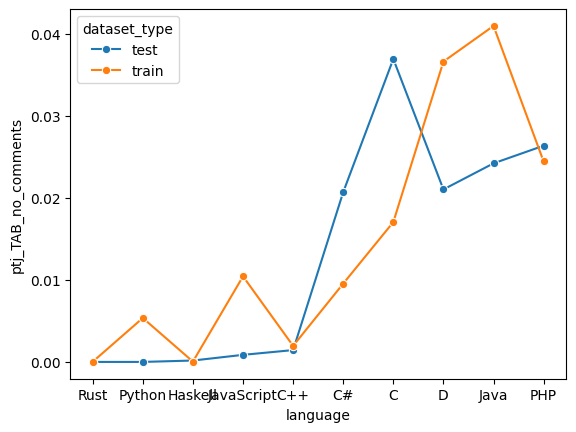

In [30]:
a = df.groupby(['language', 'dataset_type'])['ptj_TAB_no_comments'].mean().reset_index().sort_values('ptj_TAB_no_comments')
sns.lineplot(data=a, x='language', y='ptj_TAB_no_comments', hue='dataset_type', marker='o')

In [31]:
# Resulta evidenete que independientemente del dataset, sí podemos identiciar lenguajes por la cantidad de ENTER y TAB que tienen.

count    1000.000000
mean     1683.544000
std       967.377555
min       647.000000
1%        840.900000
5%       1011.000000
10%      1033.900000
25%      1127.000000
50%      1385.000000
75%      1771.000000
90%      2614.300000
95%      3458.500000
99%      6171.230000
max      8693.000000
Name: N_letras, dtype: float64


<Axes: >

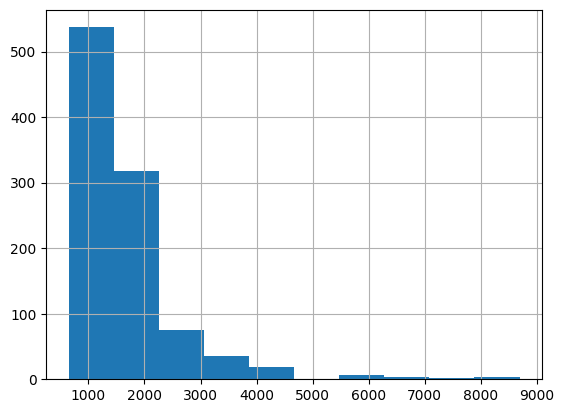

In [32]:
print(df['N_letras'].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
df['N_letras'].hist()

count    1000.000000
mean     1301.611000
std       752.231299
min       131.000000
1%        296.840000
5%        486.000000
10%       598.900000
25%       791.750000
50%      1119.500000
75%      1550.750000
90%      2200.000000
95%      2797.250000
99%      3961.170000
max      6132.000000
Name: N_letras_no_comments, dtype: float64


<Axes: >

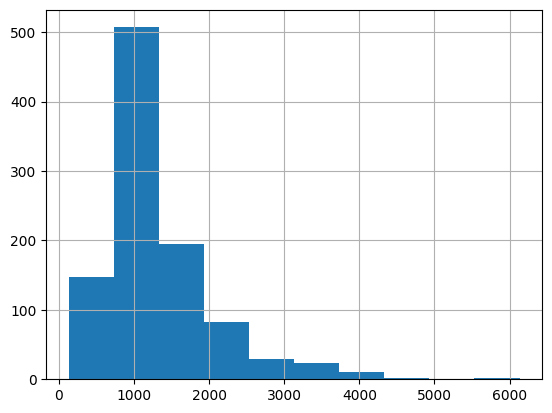

In [33]:
print(df['N_letras_no_comments'].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
df['N_letras_no_comments'].hist()

# Generación de matriz

In [34]:
letter = 'abcdefghijklmnopqrstuvwxyz'
digits = '0123456789'
others = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
alphabet = letter + digits + others
print('alphabet size:', len(alphabet))

# all-zeroes padding vector:
pad_vector = [0 for x in alphabet]

# pre-calculated one-hot vectors:
supported_chars_map = {}

for i, ch in enumerate(alphabet):
  vec = [0 for x in alphabet]
  vec[i] = 1
  supported_chars_map[ch] = vec

print('one-hot encoding for character c:', supported_chars_map['c'])

alphabet size: 68
one-hot encoding for character c: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [35]:
def turn_code_into_vector(sample, sample_vectors_size,normalize_whitespace=True):
  if normalize_whitespace:
    # Map (most) white-space to space and compact to single one:
    sample = sample.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    sample = re.sub('\s+', ' ', sample)

  # Encode the characters to one-hot vectors:
  sample_vectors = []
  for ch in sample:
    if ch in supported_chars_map:
      sample_vectors.append(supported_chars_map[ch])

  # Truncate to fixed length:
  sample_vectors = sample_vectors[0:sample_vectors_size]

  # Pad with 0 vectors:
  if len(sample_vectors) < sample_vectors_size:
    for i in range(0, sample_vectors_size - len(sample_vectors)):
      sample_vectors.append(pad_vector)

  return np.array(sample_vectors)

In [36]:
# Usamos 2797 como el tamaño de la cadena de caracteres, pues es el 95% del tamaño de mis códigos
turn_code_into_vector(df.loc[el_num_aleat, 'code'], 2797)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [37]:
df['language'].value_counts()

language
PHP           100
JavaScript    100
Rust          100
C             100
D             100
Haskell       100
Java          100
C++           100
C#            100
Python        100
Name: count, dtype: int64

In [38]:
listado_coding_languages = df['language'].value_counts().index.tolist()
listado_ys = {}
for i, pgr in enumerate(listado_coding_languages):
    vec = [0 for x in listado_coding_languages]
    vec[i] = 1
    listado_ys[pgr] = vec

In [39]:
listado_ys

{'PHP': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'JavaScript': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'Rust': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 'C': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 'D': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 'Haskell': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 'Java': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 'C++': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 'C#': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 'Python': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}

In [40]:
def genera_X_text_others_y(df, col_x_text, col_x_others, col_y, sample_vectors_size):
    X_text = []
    X_others = []
    y = []
    for n, fila in df.iterrows():

        x_text_tmp = turn_code_into_vector(fila[col_x_text], sample_vectors_size)
        X_text.append(x_text_tmp)

        x_others_tmp = fila[col_x_others]
        X_others.append(x_others_tmp)

        y_tmp = listado_ys[fila[col_y]]
        y.append(y_tmp)

    X_text = np.array(X_text)
    X_others = np.array(X_others)
    y = np.array(y)
    return X_text, X_others, y


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   file_name                1000 non-null   object 
 1   code                     1000 non-null   object 
 2   language                 1000 non-null   object 
 3   dataset_type             1000 non-null   object 
 4   code_no_comments         1000 non-null   object 
 5   code_2                   1000 non-null   object 
 6   count_ENTER              1000 non-null   int64  
 7   count_TAB                1000 non-null   int64  
 8   count_ENTER_no_comments  1000 non-null   int64  
 9   count_TAB_no_comments    1000 non-null   int64  
 10  N_letras                 1000 non-null   int64  
 11  ptj_ENTER                1000 non-null   float64
 12  ptj_TAB                  1000 non-null   float64
 13  N_letras_no_comments     1000 non-null   int64  
 14  ptj_ENTER_no_comments    

In [42]:
X_text, X_oth, y = genera_X_text_others_y(df,
                       col_x_text = 'code_no_comments',
                       col_x_others = ['ptj_TAB_no_comments', 'ptj_ENTER_no_comments'],
                       col_y = 'language',
                       sample_vectors_size=2797)

X_text_train, X_oth_train, y_train = genera_X_text_others_y(df[df['dataset_type']=='train'],
                       col_x_text = 'code_no_comments',
                       col_x_others = ['ptj_TAB_no_comments', 'ptj_ENTER_no_comments'],
                       col_y = 'language',
                       sample_vectors_size=2797)

X_text_test, X_oth_test, y_test = genera_X_text_others_y(df[df['dataset_type']=='test'],
                       col_x_text = 'code_no_comments',
                       col_x_others = ['ptj_TAB_no_comments', 'ptj_ENTER_no_comments'],
                       col_y = 'language',
                       sample_vectors_size=2797)

In [43]:
((X_text.shape, X_oth.shape, y.shape),
(X_text_train.shape,X_oth_train.shape, y_train.shape),
(X_text_test.shape, X_oth_test.shape, y_test.shape))

(((1000, 2797, 68), (1000, 2), (1000, 10)),
 ((900, 2797, 68), (900, 2), (900, 10)),
 ((100, 2797, 68), (100, 2), (100, 10)))

# Modelo

In [44]:

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Concatenate
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import plot_model

In [45]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [46]:
len(alphabet), X_text.shape[2]

(68, 68)

In [ ]:

# Params de mi LSTM
input_size_lstm_tiempos = X_text.shape[2] #len(alphabet) = 68 es el tamaño del vocalario (68 caracteres)
input_size_lstm_vector = X_text.shape[1] #len(alphabet) = 68 es el tamaño del vocalario (68 caracteres)

hidden_units_lstm = 32
num_layers_lstm = 1

# Params para mi capa Densa de otros features
input_size_other_feat = X_oth.shape[1]
dims_nn_other_feat = [4] # La longitud de esta lista indica la cantidad de capas, los valores dentro indican el tamaño de la capa
act_function_oth_feat = 'relu'

# Params de capa unión
dims_nn_union = [64] # La longitud de esta lista indica la cantidad de capas, los valores dentro indican el tamaño de la capa
act_function_union = 'relu'

# Params capa unión
act_function_final = 'softmax'
n_out = y.shape[1]



In [58]:
# Input text
input_lstm = Input(shape = (input_size_lstm_vector, input_size_lstm_tiempos, ), name='input_text')
# Input other features
input_oth_feat = Input(shape = (input_size_other_feat,), name='input_other_feat')

# LSTM para el texto
mi_lstm = input_lstm
for i in range(num_layers_lstm):
  mi_lstm = Bidirectional(LSTM(units = hidden_units_lstm,
                              return_sequences=False, # No retornamos todos los estados h para cada timestep (caracter) (en Name entity recog le pusimos True para scar los predicts de cada palabra)
                              recurrent_dropout=0.2, dropout=0.2  # Para evitar sobreajuste
                              ))(mi_lstm)
# Si le pongo return_sequences = True  ->  (None, 2797, 16) # 16 por que es num_layers_lstm*2 (num_layers_lstm=8)
# Si le pongo return_sequences = False ->  (None, 16)

# Capa densa para los features
mi_dense = input_oth_feat
for i in dims_nn_other_feat:
  mi_dense = Dense(units = i, activation = act_function_oth_feat)(mi_dense)

# Juntamos la info de ambas capas
mi_concat = Concatenate()([mi_lstm, mi_dense])
for i in dims_nn_union:
  mi_concat = Dense(units = i, activation='relu')(mi_concat)

# Capa final
output = Dense(units = n_out, activation=act_function_final)(mi_concat)

CODE_model = Model(inputs=[input_lstm, input_oth_feat], outputs = output)  # unión del modelo
CODE_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_text          │ (None, 2797, 68)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_other_feat    │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     25,856 │ input_text[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │         12 │ input_other_feat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 68)        │          0 │ bidirectional_1[… │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      4,416 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 10)        │        650 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,934 (120.84 KB)

 Trainable params: 30,934 (120.84 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
plot_model(
    CODE_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


La siguiente imagen sale de la versión cloud (donde puse a correr el modelo)
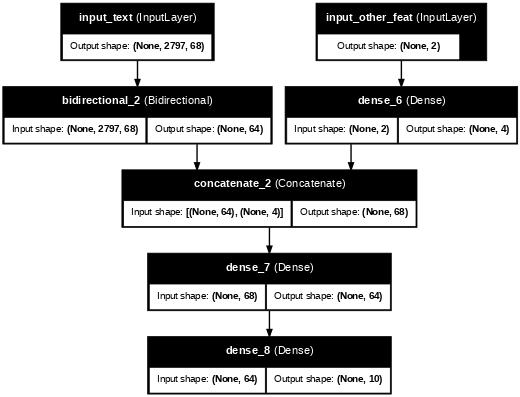

In [55]:
# Compile model
CODE_model.compile(optimizer='adam',        # el optimizador sirve para encontrar los pesos que minimizan la función de pérdida
                                            # adam: stochastic gradient descent adaptativo
                                            # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
                  loss="categorical_crossentropy", # función que evalua que tan bien el algoritmo modela el conjunto de datos
                                                   # https://www.tensorflow.org/api_docs/python/tf/keras/losses
                  metrics=['accuracy'])

In [ ]:
X_oth_train = X_oth_train.astype(np.float32)
# Como hacr fir con GPU
# https://www.tensorflow.org/install/pip
# 2 Epoch se denirarib 25min sin eso, en el mismo tiempo coalb va 19
# history = CODE_model.fit(x = [X_text_train, X_oth_train],
#                          y = y_train,
#                         validation_split=0.2,
#                         batch_size=128,
#                         epochs=20,   # número de iteraciones sobre los datos
#                         verbose=1)

In [52]:
# CODE_model.save_weights(el_path_main/'4. Analisis/Weights_CODE_model.weights.h5')

In [65]:
CODE_model.load_weights(el_path_main/'4. Analisis/Weights_CODE_model.weights.h5')

In [82]:
X_oth_test = X_oth_test.astype(np.float32)
X_oth = X_oth.astype(np.float32)

y_hat_test = CODE_model.predict([X_text_test, X_oth_test], verbose=1)
y_hat = CODE_model.predict([X_text, X_oth], verbose=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step


In [ ]:
y_hat_test.shape
# El reusltado tiene la forma esperada, es decir (n_samples, n_classes)

(100, 10)

In [ ]:
y_hat_test_idx = np.argmax(y_hat_test, axis=1)
# Sacamos el índice de la clase con mayor probabilidad

In [72]:
y_hat_test[0], y_test[0]

(array([7.5623310e-01, 5.3750236e-02, 1.1586183e-01, 3.6841448e-02,
        4.0699812e-03, 1.9411676e-02, 1.0753216e-02, 2.5602924e-03,
        6.9286078e-05, 4.4889428e-04], dtype=float32),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [ ]:
nombre_ys = listado_ys.keys()
# Creamos listado de nombres de las clases

In [ ]:
# Creamos un diccionario que nos permita saber a que clase corresponde cada índice
idx_to_label = {}
for i, label in enumerate(listado_ys):
    el_argmax = np.argmax(listado_ys[label])
    idx_to_label[el_argmax] = label

In [95]:
idx_to_label

{np.int64(0): 'PHP',
 np.int64(1): 'JavaScript',
 np.int64(2): 'Rust',
 np.int64(3): 'C',
 np.int64(4): 'D',
 np.int64(5): 'Haskell',
 np.int64(6): 'Java',
 np.int64(7): 'C++',
 np.int64(8): 'C#',
 np.int64(9): 'Python'}

In [91]:
listado_ys

{'PHP': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'JavaScript': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'Rust': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 'C': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 'D': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 'Haskell': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 'Java': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 'C++': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 'C#': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 'Python': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}

In [116]:
contador = {i:[0,0] for i in listado_ys}
# [N, N correctos]
contador

{'PHP': [0, 0],
 'JavaScript': [0, 0],
 'Rust': [0, 0],
 'C': [0, 0],
 'D': [0, 0],
 'Haskell': [0, 0],
 'Java': [0, 0],
 'C++': [0, 0],
 'C#': [0, 0],
 'Python': [0, 0]}

In [118]:
# Con el contador de arriba vamos a ver que tantos casos correctos hay
for i in range(y_test.shape[0]):

    el_lenguaje = idx_to_label[np.argmax(y_test[i])]
    el_lenguaje_pred = idx_to_label[np.argmax(y_hat_test[i])]
    contador[el_lenguaje][0] += 1 # Contamos el lenguaje real
    if el_lenguaje == el_lenguaje_pred:
        contador[el_lenguaje][1] += 1 # Contamos si el lenguaje predicho es correcto


In [120]:
contador

{'PHP': [10, 10],
 'JavaScript': [10, 7],
 'Rust': [10, 10],
 'C': [10, 8],
 'D': [10, 9],
 'Haskell': [10, 8],
 'Java': [10, 7],
 'C++': [10, 7],
 'C#': [10, 0],
 'Python': [10, 0]}

In [121]:
contador = {i:[0,0] for i in listado_ys}
# Con el contador de arriba vamos a ver que tantos casos correctos hay
for i in range(y.shape[0]):

    el_lenguaje = idx_to_label[np.argmax(y[i])]
    el_lenguaje_pred = idx_to_label[np.argmax(y_hat[i])]
    contador[el_lenguaje][0] += 1 # Contamos el lenguaje real
    if el_lenguaje == el_lenguaje_pred:
        contador[el_lenguaje][1] += 1 # Contamos si el lenguaje predicho es correcto


In [122]:
contador

{'PHP': [100, 100],
 'JavaScript': [100, 79],
 'Rust': [100, 98],
 'C': [100, 85],
 'D': [100, 94],
 'Haskell': [100, 79],
 'Java': [100, 92],
 'C++': [100, 85],
 'C#': [100, 0],
 'Python': [100, 0]}

In [ ]:
# pip install numpy pandas matplotlib seaborn openpyxl scikit-learn pydot graphviz  tensorflow torch
# Antes de ejecutar esto debes crear una copia de typing_extensions_vinicial.py, pues lo sobreescribira y la versión nueva no deja correr el código
# pip install tensorflow[and-cuda]

In [ ]:

# pushd $(dirname $(python -c 'print(__import__("tensorflow").__file__)'))
# ln -svf ../nvidia/*/lib/*.so* .
# popd
# This ensures TensorFlow can find the necessary GPU libraries
# import os
# os.system("pushd $(dirname $(python -c 'print(__import__(\"tensorflow\").__file__)')) && ln -svf ../nvidia/*/lib/*.so* . && popd")

1

In [ ]:
# ln -sf $(find $(dirname $(dirname $(python -c "import nvidia.cuda_nvcc;         
# os.system("ln -sf $(find $(dirname $(dirname $(python -c \"import nvidia.cuda_nvcc; && print(nvidia.cuda_nvcc.__file__)\"))/*/bin/) -name ptxas -print -quit) $VIRTUAL_ENV/bin/ptxas")
# print(nvidia.cuda_nvcc.__file__)"))/*/bin/) -name ptxas -print -quit) $VIRTUAL_ENV/bin/ptxas

1